## SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So we are to examine kernels for SVM algorithm applied to rather simple artificial datasets.


In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

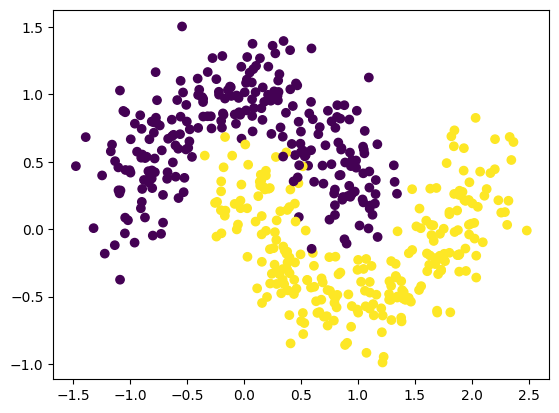

In [ ]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Let's train LR and SVM classifiers, plot their decision regions and calculate some classification metric.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

from sklearn.metrics import accuracy_score

lr = LogisticRegression(C=0.01)
svm = SVC(kernel='linear', C=10)

In [ ]:
def plot_decisions(models, names, X, y):
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(10, 8))
    for clf, lab, grd in zip(models,
                            names,
                            itertools.product([0, 1], repeat=2)):
        clf.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
        plt.title(lab)
    plt.show()

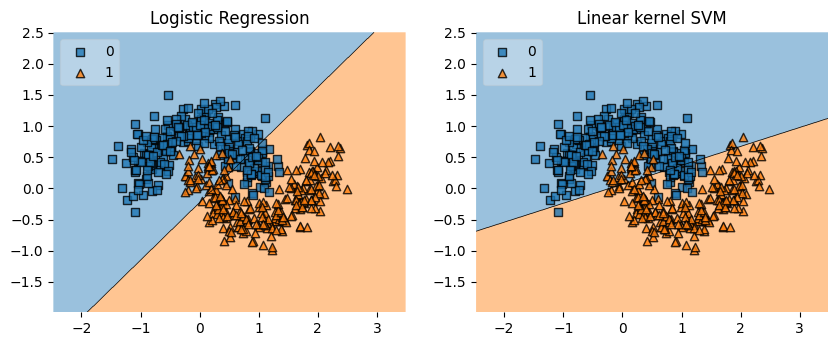

In [ ]:
plot_decisions([lr, svm], ['Logistic Regression', 'Linear kernel SVM'], moons_points, moons_labels)

In [ ]:
print('accuracy score on logreg    : ', accuracy_score(moons_labels, lr.predict(moons_points)))
print('accuracy score on linear svm: ', accuracy_score(moons_labels, svm.predict(moons_points)))

accuracy score on logreg    :  0.808
accuracy score on linear svm:  0.862


SVM turned out to be better than LR, but both accuracies are quite good, especially considering that we did not select the hyperparameters

## 1.2 Kernel tirck

Now let's use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results, play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric we've chosen eariler.


For sigmoid kernel - Best: 0.858 using {'C': 100, 'degree': 1, 'gamma': 0.001}
For rbf kernel - Best: 0.9800000000000001 using {'C': 100, 'degree': 1, 'gamma': 1}
For poly kernel - Best: 0.8959999999999999 using {'C': 5, 'degree': 3, 'gamma': 1}


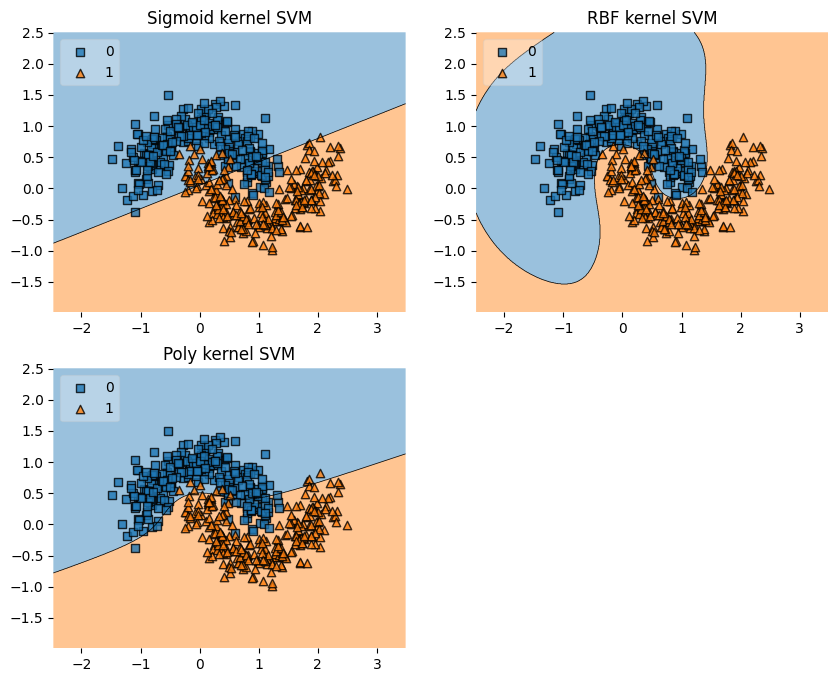

In [ ]:
from sklearn.model_selection import GridSearchCV

kernels = ['sigmoid', 'rbf', 'poly']
param_grid = {'C' : [5, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'degree' : [1, 2, 3, 4, 5, 6]
              }

svms = [SVC(kernel=kernel) for kernel in kernels]

for i in range(len(svms)):
    clf = GridSearchCV(svms[i] , param_grid)
    clf_optimal = clf.fit(moons_points, moons_labels)
    print(f"For {svms[i].kernel} kernel - Best: {clf_optimal.best_score_} using {clf_optimal.best_params_}")
    svms[i] = SVC(kernel=svms[i].kernel, C=clf_optimal.best_params_['C'], gamma=clf_optimal.best_params_['gamma'], degree=clf_optimal.best_params_['degree'])

plot_decisions(svms, ['Sigmoid kernel SVM', 'RBF kernel SVM', 'Poly kernel SVM'], moons_points, moons_labels)

In [ ]:
for svm in svms:
    print(f'accuracy score on {svm.kernel} kernel SVM: ', accuracy_score(moons_labels, svm.predict(moons_points)))

accuracy score on sigmoid kernel SVM:  0.858
accuracy score on rbf kernel SVM:  0.984
accuracy score on poly kernel SVM:  0.896


Accuracies have increased compared to logistic regression and linear SVM, except for the sigmoid, which at best degenerates into a line, which accordingly gives accuracy similar to linear SVM


## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.


Best: 0.978 using {'estimator__C': 10, 'preprocessing__degree': 7}


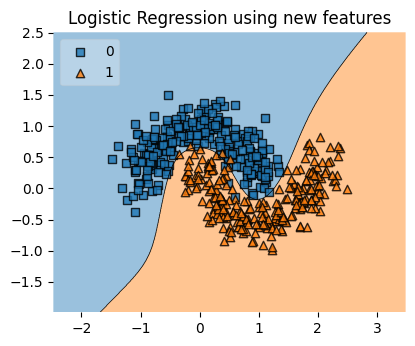

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

pipe = Pipeline([('preprocessing', PolynomialFeatures()),
                ('estimator', LogisticRegression())])

param_grid = {
    "preprocessing__degree": [2, 3, 5, 7, 9],
    "estimator__C": [100, 10, 1.0, 0.1, 0.01, 0.001]
}

clf = GridSearchCV(pipe, param_grid, n_jobs=2)
clf_optimal = clf.fit(moons_points, moons_labels)
print(f"Best: {clf_optimal.best_score_} using {clf_optimal.best_params_}")

pipe = Pipeline([('preprocessing', PolynomialFeatures(degree=clf_optimal.best_params_['preprocessing__degree'])),
                ('estimator', LogisticRegression(C=clf_optimal.best_params_['estimator__C']))])

plot_decisions([pipe], ['Logistic Regression using new features'], moons_points, moons_labels)

In [ ]:
print('accuracy score on Logistic Regression using new features: ', accuracy_score(moons_labels, pipe.predict(moons_points)))

accuracy score on Logistic Regression using new features:  0.986


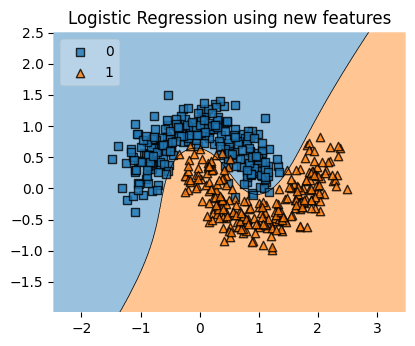

accuracy score on Logistic Regression using new features:  0.978


In [ ]:
pipe = Pipeline([('preprocessing', PolynomialFeatures(degree=3)),
                ('estimator', LogisticRegression(C=clf_optimal.best_params_['estimator__C']))])

plot_decisions([pipe], ['Logistic Regression using new features'], moons_points, moons_labels)
print('accuracy score on Logistic Regression using new features: ', accuracy_score(moons_labels, pipe.predict(moons_points)))

Similar to RBF kernel in accuracy, more similar to poly kernel with border

Degree 7 turned out to be optimal, but degree 3 used in the poly kernel is worse by 0.01

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

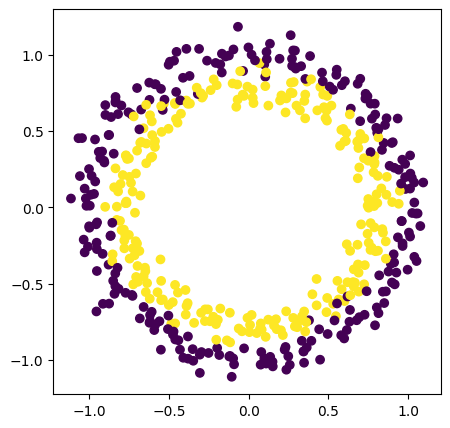

In [ ]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

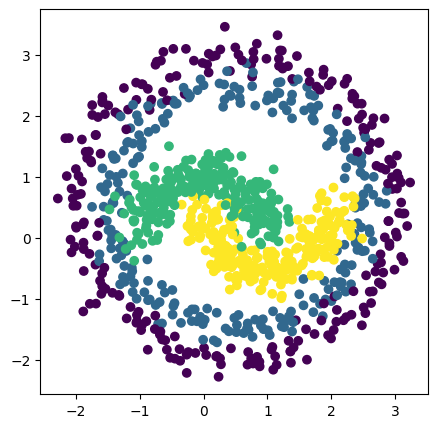

In [ ]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now let's do our best using all the approaches above!


First, let's apply logistic regression with additional features:

Best: 0.9400000000000001 using {'estimator__C': 100, 'preprocessing__degree': 5}


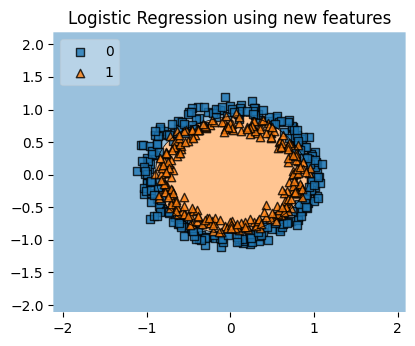

accuracy score on Logistic Regression using new features:  0.944


In [ ]:
pipe = Pipeline([('preprocessing', PolynomialFeatures()),
                ('estimator', LogisticRegression(max_iter=1000))])

param_grid = {
    "preprocessing__degree": [2, 3, 5, 7, 9],
    "estimator__C": [100, 10, 1.0, 0.1, 0.01, 0.001]
}

clf = GridSearchCV(pipe, param_grid, n_jobs=2)
clf_optimal = clf.fit(circles_points, circles_labels)
print(f"Best: {clf_optimal.best_score_} using {clf_optimal.best_params_}")

pipe = Pipeline([('preprocessing', PolynomialFeatures(degree=clf_optimal.best_params_['preprocessing__degree'])),
                ('estimator', LogisticRegression(C=clf_optimal.best_params_['estimator__C'], max_iter=1000))])

plot_decisions([pipe], ['Logistic Regression using new features'], circles_points, circles_labels)
print('accuracy score on Logistic Regression using new features: ', accuracy_score(circles_labels, pipe.predict(circles_points)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best: 0.9380000000000001 using {'estimator__C': 10, 'preprocessing__degree': 5}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


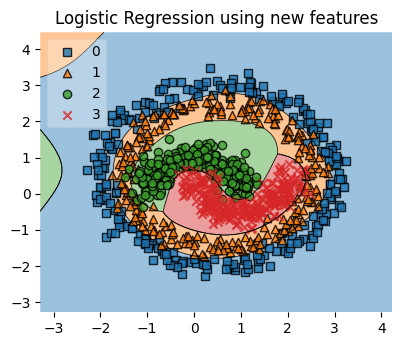

accuracy score on Logistic Regression using new features:  0.947


In [ ]:
pipe = Pipeline([('preprocessing', PolynomialFeatures()),
                ('estimator', LogisticRegression(max_iter=2000))])

param_grid = {
    "preprocessing__degree": [2, 3, 5, 7, 9],
    "estimator__C": [100, 10, 1.0, 0.1, 0.01, 0.001]
}

clf = GridSearchCV(pipe, param_grid, n_jobs=2)
clf_optimal = clf.fit(points, labels)
print(f"Best: {clf_optimal.best_score_} using {clf_optimal.best_params_}")

pipe = Pipeline([('preprocessing', PolynomialFeatures(degree=clf_optimal.best_params_['preprocessing__degree'])),
                ('estimator', LogisticRegression(C=clf_optimal.best_params_['estimator__C'], max_iter=2000))])

plot_decisions([pipe], ['Logistic Regression using new features'], points, labels)
print('accuracy score on Logistic Regression using new features: ', accuracy_score(labels, pipe.predict(points)))

The accuracy is very good, but the second dataset lacks iterations, but this is not critical. However, let's try other ways:

SVM: let's take different cores again, you never know this time we'll get a different result

For sigmoid kernel - Best: 0.508 using {'C': 10, 'degree': 1, 'gamma': 1}
For rbf kernel - Best: 0.9339999999999999 using {'C': 5, 'degree': 1, 'gamma': 0.1}
For poly kernel - Best: 0.942 using {'C': 5, 'degree': 4, 'gamma': 1}


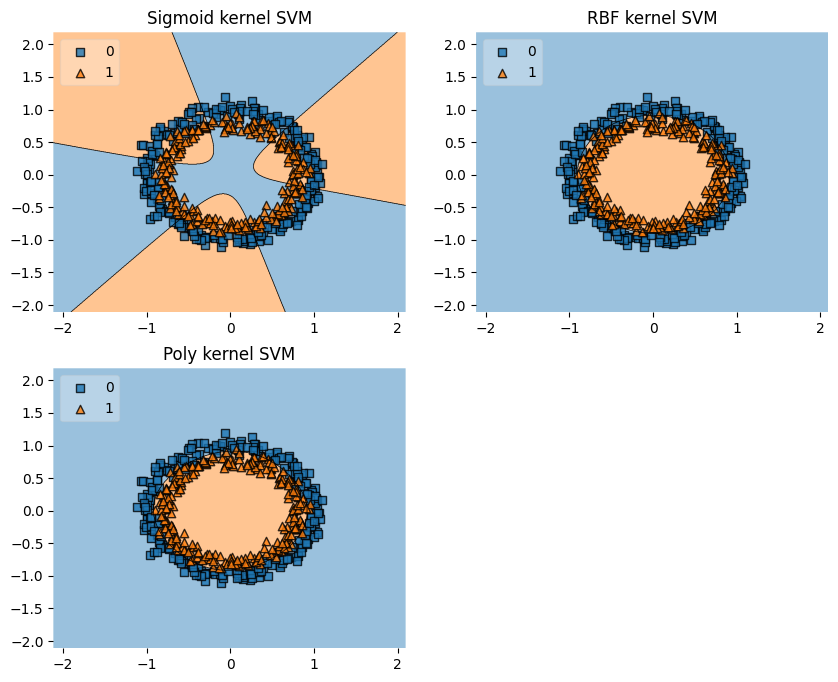

accuracy score on sigmoid kernel SVM:  0.484
accuracy score on rbf kernel SVM:  0.94
accuracy score on poly kernel SVM:  0.94


In [ ]:
kernels = ['sigmoid', 'rbf', 'poly']
param_grid = {'C' : [5, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'degree' : [1, 2, 3, 4, 5, 6, 7]
              }

svms = [SVC(kernel=kernel) for kernel in kernels]

for i in range(len(svms)):
    clf = GridSearchCV(svms[i] , param_grid)
    clf_optimal = clf.fit(circles_points, circles_labels)
    print(f"For {svms[i].kernel} kernel - Best: {clf_optimal.best_score_} using {clf_optimal.best_params_}")
    svms[i] = SVC(kernel=svms[i].kernel, C=clf_optimal.best_params_['C'], gamma=clf_optimal.best_params_['gamma'], degree=clf_optimal.best_params_['degree'])

plot_decisions(svms, ['Sigmoid kernel SVM', 'RBF kernel SVM', 'Poly kernel SVM'], circles_points, circles_labels)

for svm in svms:
    print(f'accuracy score on {svm.kernel} kernel SVM: ', accuracy_score(circles_labels, svm.predict(circles_points)))

The sigmoid kernel did not work at all, Poly and RBF worked equally, their accuracy almost coincided with regression

For rbf kernel - Best: 0.932 using {'C': 5, 'degree': 1, 'gamma': 1}


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


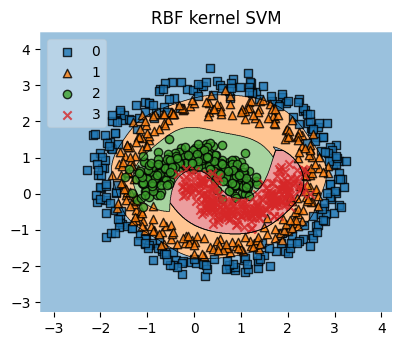

accuracy score on rbf kernel SVM:  0.941


In [ ]:
kernels = ['rbf']
param_grid = {'C' : [5, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'degree' : [1, 2, 3, 4, 5]
              }

svms = [SVC(kernel=kernel) for kernel in kernels]

for i in range(len(svms)):
    clf = GridSearchCV(svms[i] , param_grid)
    clf_optimal = clf.fit(points, labels)
    print(f"For {svms[i].kernel} kernel - Best: {clf_optimal.best_score_} using {clf_optimal.best_params_}")
    svms[i] = SVC(kernel=svms[i].kernel, C=clf_optimal.best_params_['C'], gamma=clf_optimal.best_params_['gamma'], degree=clf_optimal.best_params_['degree'])

plot_decisions(svms, ['RBF kernel SVM'], points, labels)

for svm in svms:
    print(f'accuracy score on {svm.kernel} kernel SVM: ', accuracy_score(labels, svm.predict(points)))

On this dataset, the Poly kernel did not want to work in adequate time, so given that they behaved the same with RBF, I left only RBF

Its accuracy again approximately coincides with regression

Let's try something else:

In [ ]:
!pip install catboost

In [ ]:
import catboost

In [ ]:
boosting_model = catboost.CatBoostClassifier(logging_level='Silent')

grid = {'n_estimators': [25, 50, 100, 150],
        'learning_rate' : np.linspace(0, 0.1, 5),
        'depth' : np.linspace(1, 10, 4)}

res = boosting_model.grid_search(grid,
                           circles_points,
                           circles_labels, refit=True, verbose=False)

boosting_model = catboost.CatBoostClassifier(**res['params'], logging_level='Silent')

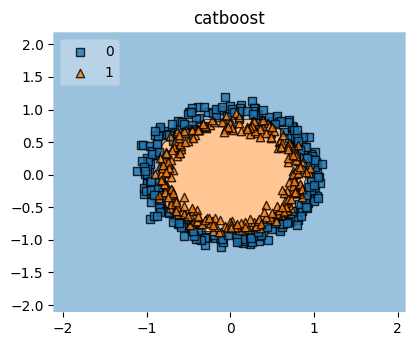

accuracy score on catboost:  0.962


In [ ]:
plot_decisions([boosting_model], ['catboost'], circles_points, circles_labels)
print('accuracy score on catboost: ', accuracy_score(circles_labels, boosting_model.predict(circles_points)))

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


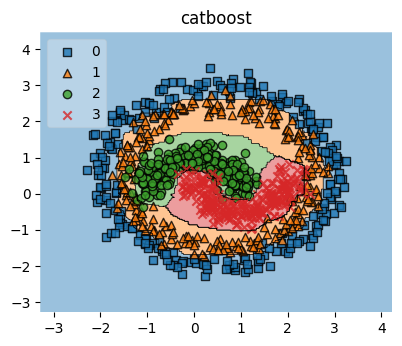

accuracy score on catboost:  0.966


In [ ]:
boosting_model = catboost.CatBoostClassifier(logging_level='Silent')

grid = {'n_estimators': [25, 50, 100, 150],
        'learning_rate' : np.linspace(0, 0.1, 5),
        'depth' : np.linspace(1, 10, 4)}

res = boosting_model.grid_search(grid,
                           points,
                           labels, refit=True, verbose=False)

boosting_model = catboost.CatBoostClassifier(**res['params'], logging_level='Silent')

plot_decisions([boosting_model], ['catboost'], points, labels)
print('accuracy score on catboost: ', accuracy_score(labels, boosting_model.predict(points)))

catboost gives an accuracy 0.02 higher than logreg and svm on both datasets